1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [1]:
import pandas as pd
import warnings
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, ClassTransformation, TwoModels
from catboost import CatBoostClassifier
from category_encoders import CatBoostEncoder


from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

warnings.filterwarnings('ignore')

In [2]:
#загружаем датасет
df = pd.read_csv('data.csv')

In [3]:
#переименовываем поля (conversion -> target, offer -> treatment) 
df.rename(columns = {'conversion':'target', 'offer':'treatment'}, inplace = True)

In [4]:
#приводим поле treatment к бинарному виду
df['treatment'] = df['treatment'].map({'Buy One Get One': 1, 'Discount': 1, 'No Offer': 0}) 

In [5]:
#разбиваем набор данных на тренировочную и тестовую выборки

dataset, target, treatment = df.drop(columns=['target', 'treatment']), df['target'], df['treatment']
X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(dataset, target, treatment, 
                                                                             test_size=0.3, shuffle=True, random_state=21)

In [6]:
#feature engineering

#выбираем категориальные признаки
cat_cols = X_train.select_dtypes(include='object').columns.tolist()

#кодируем категориальные признаки
encoder = CatBoostEncoder(cols=cat_cols)

In [7]:
# одна модель с признаком коммуникации

estimator = CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True)
sm = SoloModel(estimator=estimator)

sm_pipeline = Pipeline([
    ('encoder', encoder),
    ('model', sm)
])

sm_pipeline = sm_pipeline.fit(X=X_train, y=y_train, model__treatment=treat_train)
uplift_sm = sm_pipeline.predict(X_test)

uplift_sm = sm_pipeline.predict(X_test)
sm_score_1 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_2 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}
models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_1)
models_results['uplift@20%'].append(sm_score_2)

In [8]:
#  модель с трансформацией таргета

estimator = CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True)
ct = ClassTransformation(estimator=estimator)

ct_pipeline = Pipeline([
    ('encoder', encoder),
    ('model', ct)
])

ct_pipeline = ct_pipeline.fit(X=X_train, y=y_train, model__treatment=treat_train)
uplift_ct = ct_pipeline.predict(X_test)


ct_score_1 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_2 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransform')
models_results['uplift@10%'].append(ct_score_1)
models_results['uplift@20%'].append(ct_score_2)

In [9]:
#  две независимые модели

estimator_t = CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True)
estimator_c = CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True)

tm = TwoModels(estimator_trmnt=estimator_t, estimator_ctrl=estimator_c, method='vanilla')

tm_pipeline = Pipeline([
    ('encoder', encoder),
    ('model', tm)
])


tm_pipeline = tm_pipeline.fit(X=X_train, y=y_train, model__treatment=treat_train)

uplift_tm = tm_pipeline.predict(X_test)

tm_score_1 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_2 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_1)
models_results['uplift@20%'].append(tm_score_2)

In [10]:
pd.DataFrame(models_results)

,approach,uplift@10%,uplift@20%
0,SoloModel,0.097607,0.068816
1,ClassTransform,0.079501,0.068701
2,TwoModels,0.066717,0.062920


In [11]:
X_train

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
9748,10,172.52,0,1,Surburban,0,Web
46676,9,163.32,1,0,Surburban,1,Web
2400,8,237.56,1,0,Urban,0,Web
59443,6,59.68,0,1,Surburban,0,Web
16388,10,298.75,1,1,Urban,1,Web
...,...,...,...,...,...,...,...
16432,11,197.81,0,1,Urban,1,Phone
8964,7,358.51,1,0,Urban,1,Phone
5944,7,445.67,0,1,Surburban,1,Multichannel
5327,12,29.99,0,1,Urban,1,Web


In [12]:
X_train[cat_cols]

,zip_code,channel
9748,Surburban,Web
46676,Surburban,Web
2400,Urban,Web
59443,Surburban,Web
16388,Urban,Web
...,...,...
16432,Urban,Phone
8964,Urban,Phone
5944,Surburban,Multichannel
5327,Urban,Web


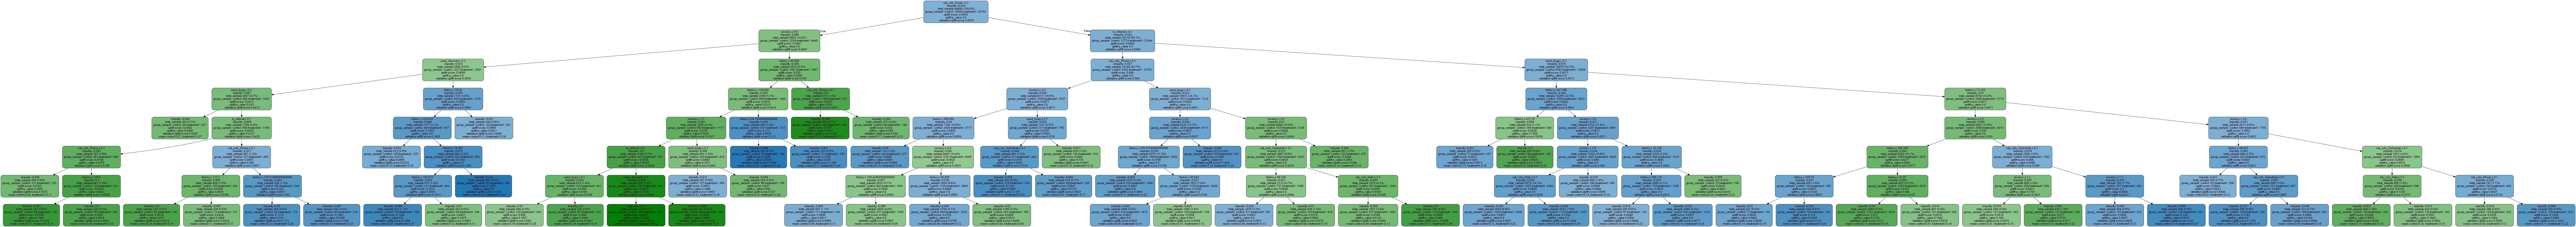

In [14]:
X_train_tree = pd.concat([X_train.drop(cat_cols, 1), 
                          pd.get_dummies(X_train[cat_cols], prefix='cat_cols')], 1)
features = [col for col in X_train_tree]

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())